<a href="https://colab.research.google.com/github/menguri/Forcasting_cryptocurrencies/blob/main/G_research_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



 # **I. Data Check**

---



In [ ]:
# import Library
import pandas as pd
pd.options.display.float_format = '{:.15f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# font download
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# data loading
# 후에 Kaggle Notebook으로 제출할 땐 module 사용해서 데이터 로딩해야 함.
train= pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/G-research/G-research/train.csv')
example_sample_submission = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/G-research/G-research/example_sample_submission.csv')
example_test = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/G-research/G-research/example_test.csv')
supplemental_train = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/G-research/G-research/supplemental_train.csv')
asset_details = pd.read_csv('/content/drive/MyDrive/Data Science/Colab Notebooks/G-research/G-research/asset_details.csv')

In [ ]:
# df_train is dataset with which you should train your model
print('--------train---------')
print(train.info())
print(train.head())
print('---------------------------------')

# details about crypto asset
print('--------asset_details---------')
print(asset_details.info())
asset_details = asset_details.sort_values(by=['Asset_ID'], axis=0, ascending=True)
print(asset_details.head())
print('---------------------------------')

# An example of the data that will be delivered by the time series API. The data is just copied from train.csv.
print('--------example_sample_submission---------')
print(example_sample_submission.info())
print(example_sample_submission.head())
print('---------------------------------')

# An example of the data that will be delivered by the time series API.
print('--------example_test---------')
print(example_test.head())
print('---------------------------------')

# this file's data will be replaced with cryptoasset prices from the submission period.
print('--------supplemental_train---------')
print(supplemental_train.head())

--------train---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB
None
    timestamp  Asset_ID  ...                  VWAP             Target
0  1514764860         2  ...  2373.116391506164746 -0.004218152387429
1  1514764860         0  ...     8.529999999999999 -0.014398966468965
2  1514764860         1  ... 13827.062092689882775 -0.014643224355736
3  1514764860         5  ...     7.657712894055892 -0.013922447007196
4  1514764860         7  ...    25.891363005206738 -0.008263505425339

[5 rows x 10 columns]
---------------------------------
--------asset_details---------
<class 'pan

# **II. Data Featuring**

---



In [ ]:
def timestamp_gap(df):
  df_range = range(int(df.index[0]), int(df.index[-1]) + 60, 60)
  df_timestamp = df.reindex(df_range, method='pad')
  return df_timestamp

In [ ]:
from tqdm import tqdm

def remove_nan(df):

  R = list()
  c = list(df['Close'])                                 # 코인 종료값 리스트
  for i in range(df.shape[0]):
    future = c[min([i+16, df.shape[0]-1])]              # (16분 후 ~ 끝시점) 중의 최솟값
    past = c[min([i+1, df.shape[0]-1])]                 # (1분 후 ~ 끝시점) 중의 최솟값
    R.append(future/past)
  R = np.array(R)

  df['pred'] = R - 1
  j = np.array(list(df['Target'].isnull()))
  new_targets = np.where(j, df['pred'], df['Target'])
  df['Target'] = new_targets
  # inf to close value
  df['VWAP'] = df['VWAP'].replace([np.inf, -np.inf], np.nan)
  # nan to 'Close'
  df['VWAP'] = df['VWAP'].fillna(df['Close'])
  return df

def remove_nan_for_predict(df):
    # inf to close value
    df['VWAP'] = df['VWAP'].replace([np.inf, -np.inf], np.nan)
      # nan to 'Close'
    df['VWAP'] = df['VWAP'].fillna(df['Close'])
    return df

In [ ]:
def upper_shadow(df):
  return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
  return np.minimum(df['Close'], df['Open'] - df['Low'])

def get_feature(df):
  df_get = df[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].copy()
  df_get['Upper_shadow'] = upper_shadow(df_get)
  df_get['Lower_shadow'] = lower_shadow(df_get)
  return df_get

def get_feature_for_predict(df):
    df_get = df[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_get['Upper_shadow'] = upper_shadow(df_get)
    df_get['Lower_shadow'] = lower_shadow(df_get)
    return df_get

In [ ]:
from scipy import stats
from scipy.stats import norm

# 로그 변환 처리를 위해 함수를 만들기
def log_return(series):
    return np.log(series).diff()

def log(df):
  df['Log_VWAP'] = np.log1p(df.VWAP)
  return df
  # log_df = pd.concat([log_return(df.VWAP, periods=5), log_return(df.VWAP, periods=1).abs()], axis=1)
  # log_df.columns = ['VAMP_5', 'VAMP_1']
  # dataframe = pd.concat([df, log_df], join='inner', axis=1)
  # return dataframe

# for predict
def log_for_predict(df):
    df['VWAP'] = log_return(df.VWAP, periods=1)

In [ ]:
# featuring
def data_featuring(df):
  feat_df = timestamp_gap(df)
  feat_df = remove_nan(feat_df)
  feat_df = get_feature(feat_df)
  feat_df = log(feat_df)
  feat_df = feat_df.drop(['Asset_ID', 'Open', 'High', 'Low', 'Close'], axis=1).fillna(0)
  return feat_df

# featuring
def data_featuring_for_predict(df):
  feat_df = timestamp_gap(df)
  feat_df = remove_nan_for_predict(feat_df)
  feat_df = get_feature_for_predict(feat_df)
  feat_df = log(feat_df)
  feat_df = feat_df.drop(['Asset_ID', 'Open', 'High', 'Low', 'Close'], axis=1).fillna(0).copy()
  return feat_df

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

def rbst_scaler(df):
  rbst_scaler = RobustScaler()
  x = df.drop('Target', axis=1).copy()
  y = df.Target
  x = x.values
  y = y.values.ravel()
  x_rbst = rbst_scaler.fit_transform(x)
  return x_rbst, y

def rbst_scaler_for_predict(df):
  rbst_scaler = RobustScaler()
  x = df.copy()
  x = x.values
  x_rbst = rbst_scaler.fit_transform(x)
  return x_rbst

In [ ]:
# Example
df_example = train[train['Asset_ID'] == 0].set_index('timestamp')
df_feature = data_featuring(df_example)
print(df_feature.head())

                        Count  ...          Log_VWAP
timestamp                      ...                  
1514764860  5.000000000000000  ... 2.254444717666111
1514764920  7.000000000000000  ... 2.253417396018835
1514764980 45.000000000000000  ... 2.251438485554585
1514765040 14.000000000000000  ... 2.249164275549055
1514765100  5.000000000000000  ... 2.246906936524096

[5 rows x 7 columns]


In [ ]:
dd_train = df_feature.drop('Target', axis = 1)
dd_target = df_feature.Target
dd_time = np.array(list(df_feature.index))

In [ ]:
x, y = rbst_scaler(df_feature)
print(x)
print(y)

[[-2.98507463e-01 -5.31346594e-01 -5.39864657e-01 -2.26293103e-01
  -3.59042553e-01 -8.48510552e-01]
 [-2.83582090e-01 -5.35325588e-01 -5.40416670e-01 -2.26293103e-01
   5.31914894e-02 -8.49764349e-01]
 [ 0.00000000e+00  3.04549609e-01 -5.41478407e-01  7.82327586e-01
   2.18085106e-01 -8.52179513e-01]
 ...
 [ 2.04477612e+00 -1.08668250e-01  1.93980859e+01  7.05818966e+00
   1.37632979e+01  3.59375787e+00]
 [ 4.05223881e+00  1.45865248e-01  1.94828517e+01  7.76939655e+00
   5.27925532e+00  3.59879993e+00]
 [ 2.86567164e+00 -6.33739020e-03  1.95220985e+01  1.63685345e+01
   1.06781915e+01  3.60112738e+00]]
[-0.01439897 -0.01587545 -0.01541013 ... -0.00098046  0.
  0.        ]


# **III. Data Visualization**

---



In [ ]:
# 코인 종류 리스트
asset_name_list = list(asset_details['Asset_Name'])             

# 코인별 데이터 준비
bin = train.query('Asset_ID == 0').set_index("timestamp")
bin = data_featuring(bin)
#
btc = train.query('Asset_ID == 1').set_index("timestamp")
btc = data_featuring(btc)
#
btc_c = train.query('Asset_ID == 2').set_index("timestamp")
btc_c = data_featuring(btc_c)
#
cda = train.query('Asset_ID == 3').set_index("timestamp")
cda = data_featuring(cda)
#
dog = train.query('Asset_ID == 4').set_index("timestamp")
dog = data_featuring(dog)
#
eos = train.query('Asset_ID == 5').set_index("timestamp")
eos = data_featuring(eos)
#
eth = train.query('Asset_ID == 6').set_index("timestamp")
eth = data_featuring(eth)
#
eth_c = train.query('Asset_ID == 7').set_index("timestamp")
eth_c = data_featuring(eth_c)
#
lot = train.query('Asset_ID == 8').set_index("timestamp")
lot = data_featuring(lot)
#
lit = train.query('Asset_ID == 9').set_index("timestamp")
lit = data_featuring(lit)
#
mak = train.query('Asset_ID == 10').set_index("timestamp")
mak = data_featuring(mak)
#
mon = train.query('Asset_ID == 11').set_index("timestamp")
mon = data_featuring(mon)
#
ste = train.query('Asset_ID == 12').set_index("timestamp")
ste = data_featuring(ste)
#
tro = train.query('Asset_ID == 13').set_index("timestamp")
tro = data_featuring(tro)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
btc.head()

,Count,Close,Volume,VWAP,Target,Upper_shadow,Lower_shadow,Log_VWAP
timestamp,,,,,,,,
1514764860,229.000000000000000,13850.176000000001295,31.550061520000000,13827.062092689882775,-0.014643224355736,163.623999999997977,169.083999999998923,9.534455291390842
1514764920,235.000000000000000,13828.102000000004409,31.046432110000005,13840.362591478491595,-0.015036539274449,217.264000000001033,155.035999999998239,9.535416677466978
1514764980,528.000000000000000,13801.314000000002125,55.061820140000066,13806.068013568094102,-0.010308656860381,176.500000000000000,222.899999999999636,9.532935914924741
1514765040,435.000000000000000,13768.040000000000873,38.780529489999992,13783.598100946479462,-0.008999254931579,196.488000000001193,226.231999999998152,9.531307168223057
1514765100,742.000000000000000,13724.914000000000669,108.501636930000004,13735.586841893864403,-0.008079397470838,189.899999999999636,211.559999999999491,9.527818124574868


1.  Volatility of Crypto Currencies

They look like moving altogether.

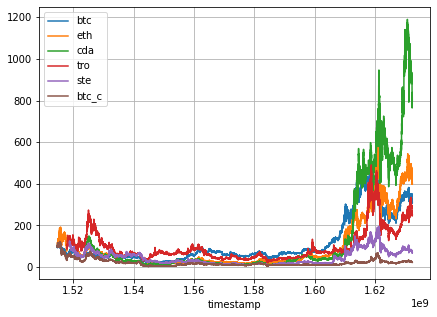

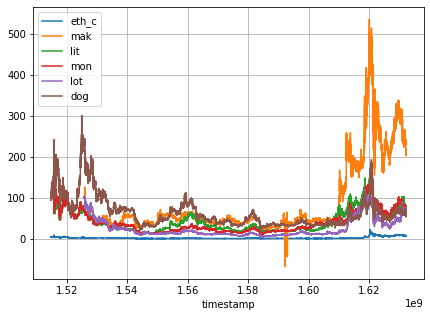

In [ ]:
# Close 값의 양상 비교 -> 처음값으로부터 얼마나 변동했는지.
# 코인들의 변동 양상이 비슷하다. 하지만 변동 정도는 제각각 다르다. 가격 예측할 때 가중치를 둬야 함. 

btc_normalization = btc.VWAP.div(btc.VWAP.iloc[0]).mul(100)
eth_normalization = eth.VWAP.div(eth.VWAP.iloc[0]).mul(100)
cda_normalization = cda.VWAP.div(cda.VWAP.iloc[0]).mul(100)
bin_normalization = bin.VWAP.div(bin.VWAP.iloc[0]).mul(100)
mak_normalization = mak.VWAP.div(mak.VWAP.iloc[0]).mul(100)
lit_normalization = lit.VWAP.div(lit.VWAP.iloc[0]).mul(100)
mon_normalization = mon.VWAP.div(mon.VWAP.iloc[0]).mul(100)
lot_normalization = lot.VWAP.div(lot.VWAP.iloc[0]).mul(100)
dog_normalization = dog.VWAP.div(dog.VWAP.iloc[0]).mul(100)
eos_normalization = eos.VWAP.div(eos.VWAP.iloc[0]).mul(100)
tro_normalization = tro.VWAP.div(tro.VWAP.iloc[0]).mul(100)
ste_normalization = ste.VWAP.div(ste.VWAP.iloc[0]).mul(100)
btc_c_normalization = btc_c.VWAP.div(btc_c.VWAP.iloc[0]).mul(100)
eth_c_normalization = eth_c.VWAP.div(eth.VWAP.iloc[0]).mul(100)


plt.figure(figsize=(7, 5))
btc_normalization.plot()
eth_normalization.plot()
cda_normalization.plot()
#bin_normalization.plot() 얘는 혼자 너무 크다.
tro_normalization.plot()
ste_normalization.plot()
btc_c_normalization.plot()
plt.legend(['btc', 'eth', 'cda', 'tro', 'ste', 'btc_c'])
plt.grid()
plt.show()


plt.figure(figsize=(7, 5))
eth_c_normalization.plot()
mak_normalization.plot()
lit_normalization.plot()
mon_normalization.plot()
lot_normalization.plot()
#dog_normalization.plot() 얘도 혼자 너무 크다.
eos_normalization.plot()
plt.legend(['eth_c', 'mak', 'lit', 'mon', 'lot', 'dog', 'eos'])
plt.grid()
plt.show()

2. Correlation with each other Crypto Currencies

High correlation. In here, we should uncover 'trigger' which move other crypto currencies. first, Let's find first mover. 

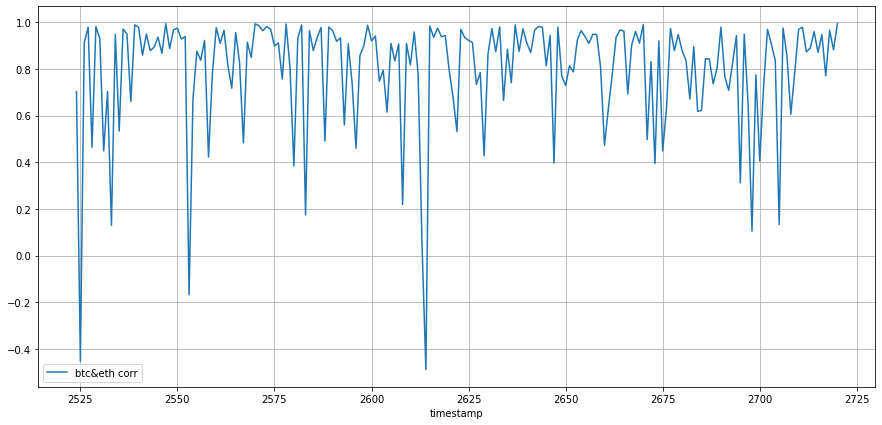

In [ ]:
# btc & eth / 아주 그냥 상관관계가 들쭉날쭉이다.

df_lret_btc = btc['VWAP'][1:]
df_lret_eth = eth['VWAP'][1:]
df_lret_btc.rename('lret_btc', inplace=True)
df_lret_eth.rename('lret_eth', inplace=True)
two_lret = pd.concat([df_lret_btc, df_lret_eth], axis=1)
btc_eth_corr = two_lret.groupby(two_lret.index//(60*10000)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

plt.figure(figsize=(15, 7))
btc_eth_corr.plot()
plt.legend(['btc&eth corr'])
plt.grid()
plt.show()

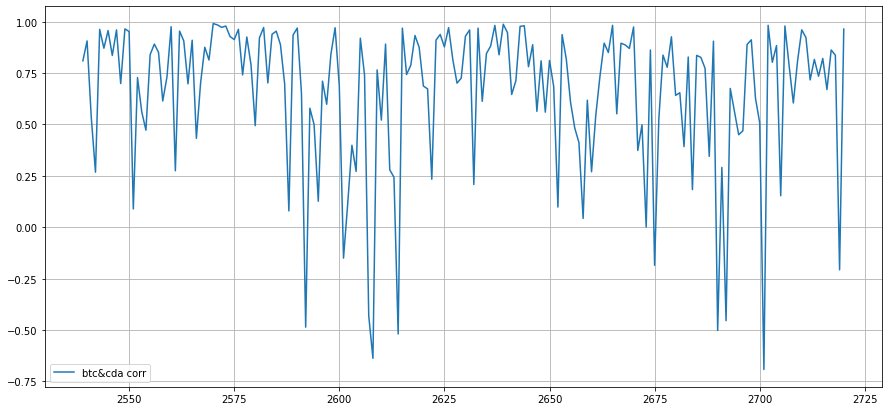

In [ ]:
# btc& cda / cda도 eth와 마찬가지로 257.5 시기에 상관관계가 떨어졌고, 그 이후에 올라가는 양상을 보이고 있다. 

df_lret_cda = cda['VWAP'][1:]
df_lret_cda.rename('lret_cda', inplace=True)
two_lret = pd.concat([df_lret_btc, df_lret_cda], axis=1)
btc_cda_corr = two_lret.groupby(two_lret.index//(60*10000)).corr().loc[:, 'lret_btc'].loc[:, 'lret_cda'][1:]                  

plt.figure(figsize=(15, 7))
btc_cda_corr.plot()
plt.legend(['btc&cda corr'])
plt.grid()
plt.show()

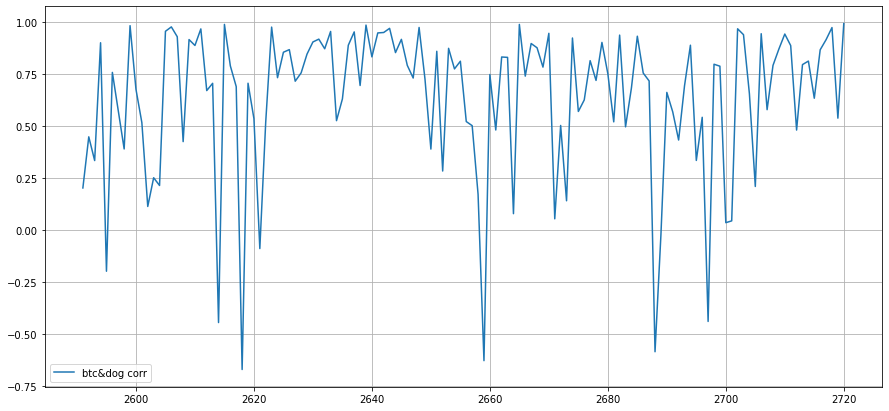

In [ ]:
# btc& dog / 도지코인도 큰 흐름으로 보았을 때, 255에서 상관도 하락/ 265에서 다시 하락/ 268에서도 다시한번 하락했다. 이는 cda, eth의 그래프와도 밀접한 상관관계를 가지고 있을 것으로 보인다. 

df_lret_dog = dog['VWAP'][1:]
df_lret_dog.rename('lret_dog', inplace=True)
two_lret = pd.concat([df_lret_btc, df_lret_dog], axis=1)
btc_dog_corr = two_lret.groupby(two_lret.index//(60*10000)).corr().loc[:, 'lret_btc'].loc[:, 'lret_dog'][1:]                  

plt.figure(figsize=(15, 7))
btc_dog_corr.plot()
plt.legend(['btc&dog corr'])
plt.grid()
plt.show()

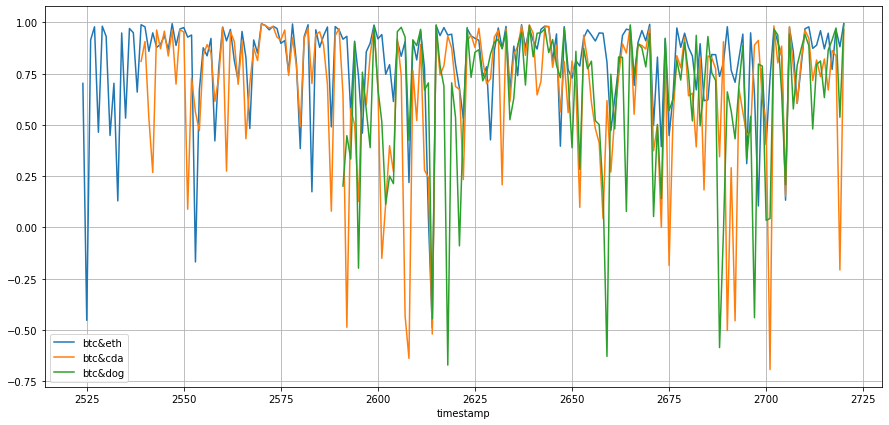

In [ ]:
# btc와 cda, eth, dog의 상관관계 그래프

plt.figure(figsize=(15, 7))
btc_eth_corr.plot()
btc_cda_corr.plot()
btc_dog_corr.plot()
plt.legend(['btc&eth', 'btc&cda', 'btc&dog'])
plt.grid()
plt.show()

In [ ]:
# 같은 양상을 보였던(일제히 상관도가 떨어졌던..) 시기 살펴보기 -> 상관성이 요동친다.
from datetime import datetime

# 1번째 하락
print('--------------------- 1st ---------------------')
timestamp = [2564, 2565, 2566, 2567, 2568, 2569, 2570]
for i in timestamp:
  time = i * (60*10000)
  datetime = datetime.fromtimestamp(time)
  print(datetime)

# 2번째 하락
print('--------------------- 2nd ---------------------')
timestamp = [2580, 2581, 2582, 2583, 2585, 2586, 2587, 2588, 2589]
for i in timestamp:
  time = i * (60*10000)
  datetime = datetime.fromtimestamp(time)
  print(datetime)


# 2018.10-2018.11 비트코인 가격 약 40% 하락
# 2019.01-2019.03 비트코인 가격 약 18% - 4,5,6월 약 90% 상승
# time = 1538400000
# datetime = datetime.fromtimestamp(time)
# datetime

--------------------- 1st ---------------------
2018-10-01 13:20:00
2018-10-08 12:00:00
2018-10-15 10:40:00
2018-10-22 09:20:00
2018-10-29 08:00:00
2018-11-05 06:40:00
2018-11-12 05:20:00
--------------------- 2nd ---------------------
2019-01-20 16:00:00
2019-01-27 14:40:00
2019-02-03 13:20:00
2019-02-10 12:00:00
2019-02-24 09:20:00
2019-03-03 08:00:00
2019-03-10 06:40:00
2019-03-17 05:20:00
2019-03-24 04:00:00


In [ ]:
# # totimestamp 변환
# totimestamp = lambda s : np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# # 모든 코인끼리의 상관관계 살피기
# from pandas.core.tools.datetimes import to_datetime

# # 빈 데이터프레임을 초기화합니다.
# all_assets_2021 = pd.DataFrame([])

# for assert_id, assert_num in zip(asset_details['Asset_ID'], asset_details['Asset_Name']):
#   asset = train.query(f'Asset_ID == {assert_id}').set_index("timestamp")
#   # 원하는 시간대 추출
#   asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]

#   # asset 간격을 60으로 맞추기
#   asset_fill_range = range(asset.index[0], asset.index[-1]+60, 60)
#   asset = asset.reindex(asset_fill_range, method='pad')

#   # 로그 변환
#   asset_lret = np.log1p(asset['VWAP'])[1:]

#   # join
#   all_assets_2021 = all_assets_2021.join(asset_lret, rsuffix=assert_num, how='outer')

In [ ]:
# all_assets_2021.head()

NameError: ignored

In [ ]:
# 암호화폐 간 연관성은 상당하다. 모든 암화화폐가 연결되어 있는 것처럼 보이지만, 
# 게임 무버가 숨어있을 가능성이 크다. 유력한 후보 : Bitcoin.
# all_assets_corr = all_assets_2021.corr()
# sns.set( rc = {'figure.figsize':(10, 8)} )
# sns.heatmap(all_assets_corr)
# plt.title('Correlation of Each other crypto currencies')
# plt.show()

NameError: ignored

3. Analysis about Target

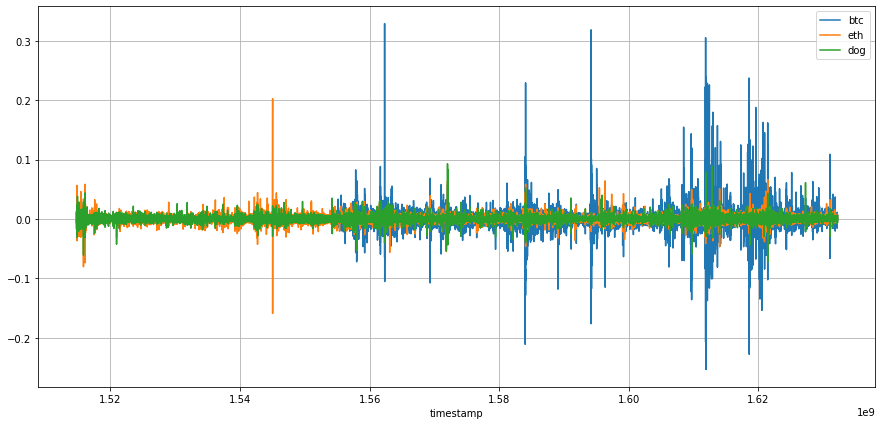

In [ ]:
btc_target = btc['Target'][1:]
eth_target = eth['Target'][1:]
dog_target = dog['Target'][1:]


plt.figure(figsize=(15, 7))
dog_target.plot()
eth_target.plot()
btc_target.plot()
plt.legend(['btc', 'eth', 'dog'])
plt.grid()
plt.show()

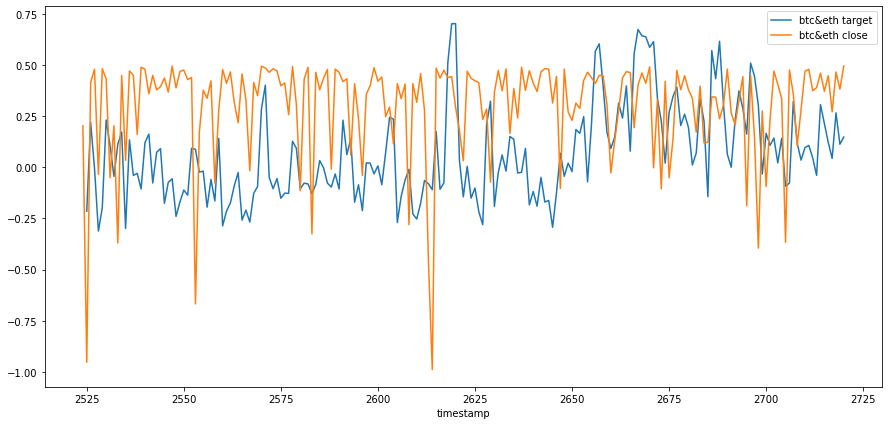

In [ ]:
# 각 암호화폐(btc, eth)의 Target 끼리의 상관관계 분석
target_btc = btc['Target'][1:]
target_eth = eth['Target'][1:]

target__mini_df = pd.concat([target_btc, target_eth], axis=1)
target__mini_df.columns = ['btc', 'eth']


# target과 close 상관관계 그래프 겹치기
# close 상관관계가 낮아질때 target 상관관계도 낮아진다. 
btc_eth_target_corr = target__mini_df.groupby(target__mini_df.index//(60*10000)).corr().loc[:, 'btc'].loc[:, 'eth'][1:]
# 그래프를 같은 위치에 두기 위해
btc_eth_corr_q = btc_eth_corr - 0.5
plt.figure(figsize=(15, 7))
btc_eth_target_corr.plot()
btc_eth_corr_q.plot()
plt.legend(['btc&eth target', 'btc&eth close'])
plt.show()

In [ ]:
# 상관관계 급상승 혹은 하락 지점 추적
target_close_be = pd.concat([btc_eth_target_corr, btc_eth_corr], axis=1)
target_close_be.columns = ['Target', 'Close']
soaring_target_time = target_close_be[target_close_be['Target'] > 0.3]
soaring_close_time = target_close_be[target_close_be['Close'] < 0.4]

# target 상관성 급상승
for i in list(soaring_target_time.index):
  time = i * (60*10000)
  datetime = datetime.fromtimestamp(time)
  print(datetime)
print('-------------------')

# close 상관성 급하락 지점
for i in list(soaring_close_time.index):
  time = i * (60*10000)
  datetime = datetime.fromtimestamp(time)
  print(datetime)

2018-11-19 04:00:00
2019-10-11 13:20:00
2019-10-18 12:00:00
2019-10-25 10:40:00
2019-12-26 22:40:00
2020-07-01 10:40:00
2020-07-08 09:20:00
2020-07-15 08:00:00
2020-08-12 02:40:00
2020-08-26 00:00:00
2020-09-08 21:20:00
2020-09-15 20:00:00
2020-09-22 18:40:00
2020-09-29 17:20:00
2020-10-06 16:00:00
2020-10-13 14:40:00
2020-10-20 13:20:00
2020-11-17 08:00:00
2020-11-24 06:40:00
2021-01-04 22:40:00
2021-01-25 18:40:00
2021-02-01 17:20:00
2021-02-08 16:00:00
2021-02-15 14:40:00
2021-03-15 09:20:00
2021-04-05 05:20:00
2021-04-12 04:00:00
2021-04-19 02:40:00
2021-06-20 14:40:00
2021-08-08 05:20:00
-------------------
2018-01-03 17:20:00
2018-02-28 06:40:00
2018-07-17 04:00:00
2019-01-20 16:00:00
2019-02-10 12:00:00
2019-08-03 02:40:00
2019-09-06 20:00:00
2019-09-13 18:40:00
2020-04-29 22:40:00
2020-10-27 12:00:00
2021-03-29 06:40:00
2021-04-19 02:40:00
2021-06-06 17:20:00


Remove Noise

In [ ]:
# moving_average
#[bin, btc, btc_c, cda, dog, eos, eth, eth_c, lot, lit, mak, mon, ste, tro]
moving_average = btc['Close'].rolling(window=7200).mean()

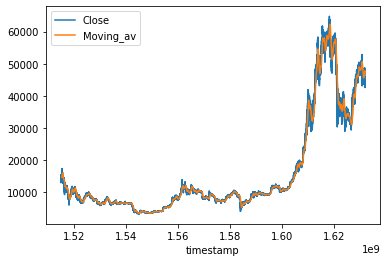

In [ ]:
# plotly graph
# 5일 단위라서 많이 겹쳐 보인다.
# btc_moving = btc.moving_average
btc_close = btc.Close

btc_close.plot()
moving_average.plot()
plt.legend(['Close', 'Moving_av'])
plt.show()

4. should find soaring Volume/Count for weight

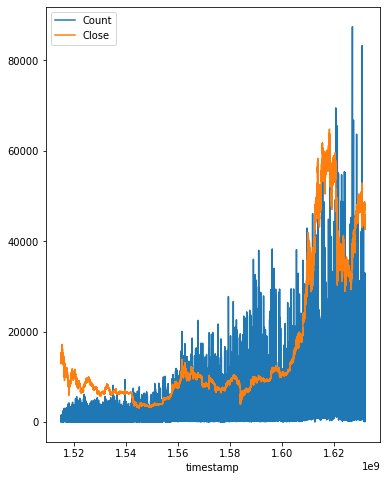

In [ ]:
plt.figure(figsize=(6, 8))
btc['Count'].plot()
btc['Close'].plot()
plt.legend(['Count', 'Close'])
plt.show()

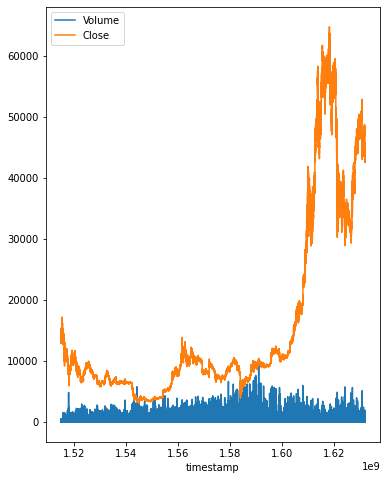

In [ ]:
plt.figure(figsize=(6, 8))
btc['Volume'].plot()
btc['Close'].plot()
plt.legend(['Volume', 'Close'])
plt.show()

In [ ]:
# We can find soaring volume/count before strong moving.
# btcc = btc.copy()
# btcc_normalization = btcc.Volume_Increasing.div(btcc.Volume_Increasing.iloc[0]).mul(100)
# VWAP_normalization = btcc.VWAP.div(btcc.VWAP.iloc[0]).mul(100)


# plt.figure(figsize=(6, 8))
# plt.subplot(3,1,1)
# btcc['Volume_Increasing'][500:1000].plot()
# plt.legend(['Volume_Increasing'])
# plt.show()

# plt.figure(figsize=(6, 8))
# plt.subplot(3,1,2)
# btcc['Count_Increasing'][500:1000].plot()
# plt.legend(['Count_Increasing'])
# plt.show()

# plt.figure(figsize=(6, 8))
# plt.subplot(3,1,3)
# VWAP_normalization[500:1000].plot()
# plt.legend(['VWAP'])
# plt.show()

AttributeError: ignored

5. Corelation in dataframe

In [ ]:
# couldn't find high correlation in Target  
btc_corr = btc.corr()
btc_corr

In [ ]:
sns.set( rc = {'figure.figsize':(8, 8)} )
sns.heatmap(btc_corr)
plt.title('Corelation in dataframe')
plt.show()

# **IV. Defining Train**

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression 
import lightgbm as lgb
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
lgb_model = LGBMRegressor(
    objective='regression',
    num_leaves=100,
    max_depth=5,
    learning_rate=0.1,
    is_training_metric=True)

logis_model = LogisticRegression()

lasso_model = linear_model.Lasso(alpha=0.1)

In [ ]:
class training_step:

  def __init__(self):
    self.model = LGBMRegressor(objective='regression', metric='rmse')      # num_iteration=1000, early_stopping_rounds= 20
    self.parameters = {
        'num_leaves' : [50, 100, 200],
        'max_depth' : [3, 5, 7],
        #'min_data_in_leaf' : [500, 1000],
        'learning_rate' : [0.1, 0.01, 0.05]
    }

  def all_featuring(self, df):
    crypto_df = data_featuring(df).copy()
    x, y = rbst_scaler(crypto_df)
    return x, y

  def featuring_for_predicting(self, df):
    crypto_df = data_featuring_for_predict(df).copy()
    print(crypto_df)
    x = rbst_scaler_for_predict(crypto_df)
    return x 
  
  def best_params(self, df):
    grid_search = GridSearchCV(self.model, param_grid= self.parameters, cv=5, n_jobs = -1, verbose=True)
    x, y = self.all_featuring(df)
    grid_search.fit(x, y)
    best_esti = grid_search.best_estimator_
    return best_esti
    #LGBMRegressor.plot_metric(self.model)

In [ ]:
training = training_step()
new_models = {}
for asset_id, asset_name in zip(asset_details['Asset_ID'], 
                                asset_details['Asset_Name']):
    print(f'------{asset_name} training-----')
    asset_train = train[train['Asset_ID'] == asset_id].set_index('timestamp')
    line = (len(asset_train)//3)*2
    train_df = asset_train[:line]
    test_x, test_y = training.all_featuring(asset_train[line:])
    model = training.best_params(asset_train)
    print(f'{asset_name} score = {model.score(test_x, test_y)}')
    new_models[asset_id] = model

------Binance Coin training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Binance Coin score = 0.0004845322245331518
------Bitcoin training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Bitcoin score = -0.0002129877337488928
------Bitcoin Cash training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Bitcoin Cash score = -0.0014047134772872116
------Cardano training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Cardano score = -0.0005909577057321425
------Dogecoin training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Dogecoin score = -0.0013965309322307995
------EOS.IO training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
EOS.IO score = -0.0019204309654976548
------Ethereum training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Ethereum score = 0.0005102968425895194
------Ethereum Classic training-----
Fitting 5 folds for each of 27 candidate

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Maker score = -0.0010593800765927863
------Monero training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Monero score = -0.013102664783976925
------Stellar training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Stellar score = -0.0022890750174413554
------TRON training-----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
TRON score = -0.0001566525223541948


In [ ]:
# simple prediction - bitcoin
training = training_step()
line = (len(dog)//3)*2
train_dog = dog[:line]
test_dog = dog[line:]
# train_x, train_y = rbst_scaler(train_dog)
# test_x, test_y = rbst_scaler(test_dog)
train_x = train_dog.drop('Target', axis=1)
train_x = train_x.values
train_y = train_dog.Target
train_y = train_y.values   #.ravel()
test_x = test_dog.drop('Target', axis=1)
test_y = test_dog.Target
test_x = test_x.values
test_y = test_y.values     #.ravel()


lgb_model.fit(train_x, train_y, eval_set=[(test_x, test_y),(train_x, train_y) ], verbose=20, eval_metric='logloss')
lgb_prediction = lgb_model.predict(test_x)
print(f'lgb_model score : {lgb_model.score(test_x, test_y)}')

# logis_model.fit(train_x, train_y)
# logis_prediction = logis_model.predict(test_x)
# print(f'logis_model score : {logis_model.score(test_x, test_y)}')

lasso_model.fit(train_x, train_y)
lasso_prediction = lasso_model.predict(test_x)
print(f'lasso_model score : {lasso_model.score(test_x, test_y)}')

[20]	training's l2: 2.55675e-05	valid_0's l2: 0.000931171
[40]	training's l2: 2.53757e-05	valid_0's l2: 0.00106466
[60]	training's l2: 2.52422e-05	valid_0's l2: 0.00114051
[80]	training's l2: 2.51261e-05	valid_0's l2: 0.00112637
[100]	training's l2: 2.50207e-05	valid_0's l2: 0.00114196
lgb_model score : -9.260608468227025
lasso_model score : 0.0006619900401850787


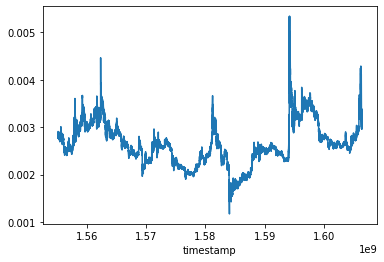

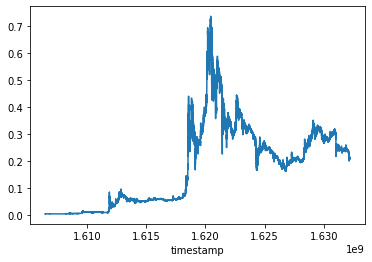

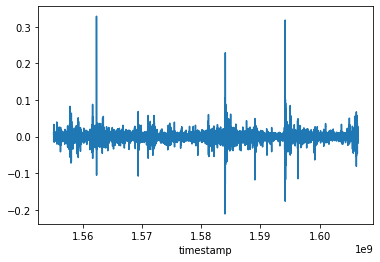

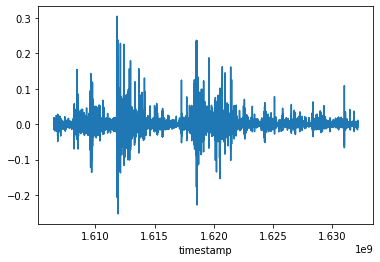

In [ ]:
xx = train_dog.VWAP
xx_test = test_dog.VWAP
xx.plot()
plt.show()

xx_test.plot()
plt.show()


yy = train_dog.Target
yy_test = test_dog.Target
yy.plot()
plt.show()

yy_test.plot()
plt.show()

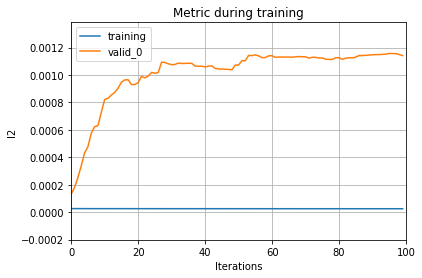

In [ ]:
lgb.plot_metric(lgb_model)

In [ ]:
lasso_prediction = lasso_prediction * 50

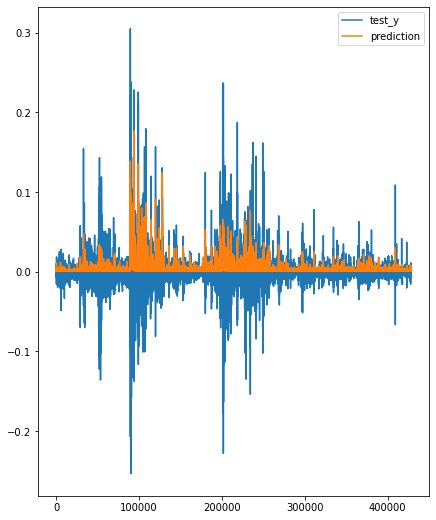

In [ ]:
# prediction과 실제 값의 차이가 많이 나고 있다. (오류를 범하고 있다는 뜻)
# prediction과 test_y 사이의 단위오류는 발생하지 않았음.
# 증폭시켜야 하는 것인가? 
lasso_prediction = pd.Series(lasso_prediction)
test_y = pd.Series(test_y)
#plot 
plt.figure(figsize=(7,9))
test_y.plot()
lasso_prediction.plot()
plt.legend(['test_y', 'prediction'])
plt.show()

## **V. Test Environment**

In [ ]:
example_sample_submission.head()

,group_num,row_id,Target
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


In [ ]:
# group_num (max) -> 3
example_test.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
0,1623542400,3,1201.000000000000000,1.478555833333333,1.486030000000000,1.478000000000000,1.483681333333333,654799.561103221611120,1.481439388473112,0,0
1,1623542400,2,1020.000000000000000,580.306666666666729,583.889999999999986,579.909999999999968,582.276666666666756,1227.988327533804522,581.697038402370254,0,1
2,1623542400,0,626.000000000000000,343.789499999999975,345.108000000000004,343.639999999999986,344.598000000000013,1718.832568629999969,344.441729055895848,0,2
3,1623542400,1,2888.000000000000000,35554.289631921434193,35652.464650139998412,35502.669999999998254,35602.004285714283469,163.811536648950096,35583.469303033794858,0,3
4,1623542400,4,433.000000000000000,0.312167000000000,0.312600000000000,0.311920000000000,0.312208400000000,585577.410442026448436,0.312154069775008,0,4


In [ ]:
example_test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  56 non-null     int64  
 1   Asset_ID   56 non-null     int64  
 2   Count      56 non-null     float64
 3   Open       56 non-null     float64
 4   High       56 non-null     float64
 5   Low        56 non-null     float64
 6   Close      56 non-null     float64
 7   Volume     56 non-null     float64
 8   VWAP       56 non-null     float64
 9   group_num  56 non-null     int64  
 10  row_id     56 non-null     int64  
dtypes: float64(7), int64(4)
memory usage: 4.9 KB


In [ ]:
# G-research 방식대로 test환경 조성

sub_dict = {}
test_dict = {}
for i in [0, 1, 2, 3]:
  # group_num 제거
  test_dict[i] = example_test[example_test['group_num'] == i].drop('group_num', axis=1)
  sub_dict[i] = example_sample_submission[example_sample_submission['group_num'] == i]

my_dict = {'timestamp': [0], 'Asset_ID': [0], 'Count': [0], 'Open' : [0], 'Close':[0], 'High':[0], 'Low':[0], 'Volume':[0], 'VWAP':[0], 'row_id':[0]}
dataframe = pd.DataFrame(my_dict)

In [ ]:
# test환경
# test로 입력되는 값들을 저장해두면서 동시에 데이터 프레임에 새로운 값을 넣어주는 것도 가능할 것 같아. 
training = training_step()

for i in [0,1,2,3]:
  df_pred = sub_dict[i]
  dataframe = pd.concat([dataframe, test_dict[i]])
  for j, row in test_dict[i].iterrows():
    df_row = pd.DataFrame(row).T
    df = df_row.set_index('timestamp')
    df = df.drop('row_id', axis=1)
    # model
    model = new_models[row['Asset_ID']]
    # featuring
    x_test = training.featuring_for_predicting(df)
    y_pred = model.predict(x_test)
    df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
  print(df_pred)

dataframe.head()

                          Count  ...          Log_VWAP
timestamp                        ...                  
1623542400 1201.000000000000000  ... 0.908838790388647

[1 rows x 6 columns]
                          Count  ...          Log_VWAP
timestamp                        ...                  
1623542400 1020.000000000000000  ... 6.367667391593415

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542400 626.000000000000000  ... 5.844823972126527

[1 rows x 6 columns]
                          Count  ...           Log_VWAP
timestamp                        ...                   
1623542400 2888.000000000000000  ... 10.479664566120233

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542400 433.000000000000000  ... 0.271670114858341

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp     

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542400 35.000000000000000  ... 0.694614020548969

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542400 560.000000000000000  ... 5.095168277061529

[1 rows x 6 columns]
                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542400 61.000000000000000  ... 7.988241143412657

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542400 229.000000000000000  ... 0.065935521314118

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542400 383.000000000000000  ... 0.284112032309820

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 458.000000000000000  ... 5.844091270348820

[1 rows x 6 columns]
                          Count  ...           Log_VWAP
timestamp                        ...                   
1623542460 2006.000000000000000  ... 10.479703680549186

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 573.000000000000000  ... 0.271499097152607

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 644.000000000000000  ... 1.764290604586507

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 530.000000000000000  ... 4.030081403507269

[1 rows x 6 columns]
                          Count  ...          Log_VWAP
timestamp          

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542460 35.000000000000000  ... 7.988757809693301

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 395.000000000000000  ... 0.065976060000442

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542460 287.000000000000000  ... 0.284086909864321

[1 rows x 6 columns]
                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542460 62.000000000000000  ... 5.498550047949087

[1 rows x 6 columns]
    group_num  row_id             Target
14          1      14 -0.000025340985736
15          1      15 -0.000017043088137
16          1      16  0.000007694958659
17          1      17 -0.000003694831973
18          1      18  0.000015755279395
19          1      19 -0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                          Count  ...          Log_VWAP
timestamp                        ...                  
1623542520 1667.000000000000000  ... 0.270890131920412

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542520 380.000000000000000  ... 1.762043483003228

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542520 825.000000000000000  ... 4.027060589850076

[1 rows x 6 columns]
                          Count  ...          Log_VWAP
timestamp                        ...                  
1623542520 1856.000000000000000  ... 7.769855205680118

[1 rows x 6 columns]
                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542520 53.000000000000000  ... 0.692621406900615

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp              

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542520 338.000000000000000  ... 0.065840646338828

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542520 264.000000000000000  ... 0.283430365648591

[1 rows x 6 columns]
                        Count  ...          Log_VWAP
timestamp                      ...                  
1623542520 49.000000000000000  ... 5.494915977827055

[1 rows x 6 columns]
    group_num  row_id             Target
28          2      28 -0.000025340985736
29          2      29 -0.000017043088137
30          2      30  0.000007694958659
31          2      31 -0.000003694831973
32          2      32  0.000015755279395
33          2      33 -0.000004433309028
34          2      34  0.000043189198106
35          2      35 -0.000004125906076
36          2      36 -0.000021552305597
37          2      37 -0.000010133487247


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542580 465.000000000000000  ... 1.760491362551386

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542580 347.000000000000000  ... 4.024891813369987

[1 rows x 6 columns]
                          Count  ...          Log_VWAP
timestamp                        ...                  
1623542580 2624.000000000000000  ... 7.767854025336770

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542580 169.000000000000000  ... 0.689627911545194

[1 rows x 6 columns]
                         Count  ...          Log_VWAP
timestamp                       ...                  
1623542580 431.000000000000000  ... 5.091264595345791

[1 rows x 6 columns]
                        Count  ...          Log_VWAP
timestamp               

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,timestamp,Asset_ID,Count,Open,Close,High,Low,Volume,VWAP,row_id
0,0,0,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0
0,1623542400,3,1201.000000000000000,1.478555833333333,1.483681333333333,1.486030000000000,1.478000000000000,654799.561103221611120,1.481439388473112,0
1,1623542400,2,1020.000000000000000,580.306666666666729,582.276666666666756,583.889999999999986,579.909999999999968,1227.988327533804522,581.697038402370254,1
2,1623542400,0,626.000000000000000,343.789499999999975,344.598000000000013,345.108000000000004,343.639999999999986,1718.832568629999969,344.441729055895848,2
3,1623542400,1,2888.000000000000000,35554.289631921434193,35602.004285714283469,35652.464650139998412,35502.669999999998254,163.811536648950096,35583.469303033794858,3
